# Advanced ML with scikit-learn
<p>
Bern, 2024<br>
Prepared by Mykhailo Vladymyrov.
</p>

This work is licensed under a <a href="https://creativecommons.org/licenses/by-nc-sa/4.0/">Creative Commons Attribution-NonCommercial-ShareAlike 4.0 International License</a>.


This course is designed to guide students in building a complete end to end studies involing Machine learning based tools.


* Data inspection with non-linear embedding
* Probabililistic gaussian clustering
* K means - cluster number selection and metric selection
* Clustering discrete data
* Data Normalization
* Data imputation
* Pipelines
* Data IO
* Visualization techniques and interactive visualizations


We focus here not as much on the tools used, as on the way of thinking, and approaching the task at hand.

# Imports and utils

If you work on the Colab - you can install the packages with `!pip install package_name`:

`!pip install dash hdbscan impyute kmodes plotly pyod scikit-learn==1.3 umap-learn`


If you work on your local machine, please run your miniforge environment and install the packages like this:

`mamba install dash hdbscan kmodes plotly pyod umap-learn`

`pip install impyute`


To export the environment to a file, you can run

`mamba env export > environment.yml`


To create the environment from the file, you can run

`mamba env create -f environment.yml`

In [ ]:
import os
import requests
import tarfile

import pandas as pd
import numpy as np

from scipy.stats import kurtosis
from scipy.stats import skew

from sklearn.model_selection import train_test_split
import matplotlib.colors as mcolors

# dimensionality reduction
import umap
from sklearn.decomposition import PCA

# clustering kmeans, gaussian
from sklearn.cluster import KMeans
from sklearn.cluster import HDBSCAN
from sklearn.mixture import GaussianMixture
from kmodes.kmodes import KModes
from kmodes.kprototypes import KPrototypes

# metrics for clustering
from sklearn.metrics import silhouette_samples, silhouette_score
from sklearn.metrics import calinski_harabasz_score
from sklearn.metrics import davies_bouldin_score

# classification report and metrics
from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score, confusion_matrix, f1_score, precision_score, recall_score, roc_auc_score, roc_curve
# confusion matrix display
from sklearn.metrics import ConfusionMatrixDisplay

#regression metrics:
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

# preprocessing
from sklearn.preprocessing import PowerTransformer, OrdinalEncoder, OneHotEncoder, StandardScaler, MinMaxScaler, RobustScaler, LabelEncoder

# imputations
from pyod.models.ecod import ECOD

from sklearn.impute import SimpleImputer
from sklearn.impute import KNNImputer
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer

from impyute.imputation.cs import mice

# pipelines
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import PolynomialFeatures
from sklearn.preprocessing import FunctionTransformer

# a model
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV

# dataset
from sklearn.datasets import fetch_california_housing

# visualizations
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
from dash import Dash, html, dcc, Input, Output, callback

# utils
from tqdm.auto import tqdm
from joblib import dump, load

In [ ]:
# utility functions

def psc():
    plt.show()
    plt.close()
    
def ptcs():
    plt.tight_layout()
    psc()

# Step 0: study your data

The first step in any data analysis is to study the data. You are the domain expert, and you know your data the best. Yet there are always ways to see the data from a different angle, and to get a better understanding of it.

Furthermore, the data might be corrupted, or have missing values, or be in a format that is not suitable for the task at hand.
Thus, the first step is to inspect the data, and to make sure it is in a format that is suitable for the task at hand. 

## First inspection

In [ ]:
# load house prices dataset

data = fetch_california_housing()
print(data.keys())

In [ ]:
print(data.DESCR)
print(data.feature_names)
print(data.target_names)

In [ ]:
x, y = data.data, data.target

In [ ]:
print(x.shape, y.shape)

In [ ]:
xy = np.concatenate((x, y.reshape(-1, 1)), axis=1)
print(xy.shape)

df = pd.DataFrame(xy, columns=data.feature_names + data.target_names)

In [ ]:
df.head()

In [ ]:
df.describe().T

In [ ]:
%%time
# make pairplot of the data and target

sns.pairplot(df)

In the dense area there are so many points, that we can't really see the distrinution. We can use the Kernel Density Estimation (KDE) plot

In [ ]:
%%time
# as we can see making kde pairplot takes a lot of time.
# we can subsample the data to make it faster
# subsample the data to 10%
df_sub = df.sample(frac=0.1)
print(df_sub.shape)

# make PairGrid of the data and target as:
g = sns.PairGrid(df_sub)
# kde on upper triangle
g.map_upper(sns.kdeplot, n_levels=10)

# scatter on lower triangle
# complement lower triangle with overlayed correlation line in red and scatter plot in blue, 5% opacity, marker size small
g.map_lower(sns.regplot, scatter_kws={'color': 'blue', 'alpha': 0.1, 's': 15}, line_kws={'color': 'red', 'alpha': 0.3})

# and on diagonal a histogram
g.map_diag(sns.histplot, multiple='stack')

In [ ]:
# make pca of the x data, same number of components as the original data
n_components = x.shape[1]
pca = PCA(n_components=n_components)

x_pca = pca.fit_transform(x)

print(x_pca.shape)
# plot explained variance
plt.plot(pca.explained_variance_ratio_);

In [ ]:
# make 2d scatter plot of the pca data with seaborn

ax = sns.scatterplot(x=x_pca[:, 0], y=x_pca[:, 1], hue=y)
ax.set(xlabel='PCA 1', ylabel='PCA 2')
psc()

In [ ]:
# make 2d kd plot of the pca data with seaborn

# again, this takes a lot of time, so we could subsample the data

ax = sns.kdeplot(x=x_pca[:, 0], y=x_pca[:, 1])
ax.set(xlabel='PCA 1', ylabel='PCA 2')
psc()

In [ ]:
# make 3d scatter plot of the pca data with plotly

px.scatter_3d(x=x_pca[:, 0], y=x_pca[:, 1], z=x_pca[:, 2], color=y, opacity=0.7, labels={'x': 'PCA 1', 'y': 'PCA 2', 'z': 'PCA 3'})

what do you notice about the data? in the last two plots?
do you see anything odd?

## Normalization

In [ ]:
x_orig = x.copy()
y_orig = y.copy()

In [ ]:
# perform normalization of the x and y data sing standard scaler

scaler_x = StandardScaler()
scaler_y = StandardScaler()
x = scaler_x.fit_transform(x)
y = scaler_y.fit_transform(y.reshape(-1, 1)).reshape(-1)


In [ ]:
# print normalization coefficients

print(scaler_x.mean_, scaler_x.var_)
print(scaler_y.mean_, scaler_y.var_)

In [ ]:
# you can always inverse transform the data to see if it is correct

x_inv = scaler_x.inverse_transform(x)
y_inv = scaler_y.inverse_transform(y.reshape(-1, 1)).reshape(-1)

In [ ]:
# print mean and variance of the transformed data

print(x.mean(axis=0), x.var(axis=0))
print(y.mean(), y.var())

In [ ]:
# print mean and variance of the inverse transformed data

print(x_inv.mean(axis=0), x_inv.var(axis=0))
print(y_inv.mean(), y_inv.var())

In [ ]:
# print mean and variance of the original data

print(x_orig.mean(axis=0), x_orig.var(axis=0))
print(y_orig.mean(), y_orig.var())

## Non-linear embedding

In [ ]:
%%time
# make 2D and 3D umap of the x data

umap_2d = umap.UMAP(n_components=2, n_neighbors=30, min_dist=0.1)
umap_3d = umap.UMAP(n_components=3, n_neighbors=30, min_dist=0.1)

x_umap_2d = umap_2d.fit_transform(x)
x_umap_3d = umap_3d.fit_transform(x)

print(x_umap_2d.shape, x_umap_3d.shape)

In [ ]:
# plot 2d umap with seaborn

sns.scatterplot(x=x_umap_2d[:, 0], y=x_umap_2d[:, 1], hue=y);

In [ ]:
%%time
# plot 2d umap with seaborn as KDE

sns.kdeplot(x=x_umap_2d[:, 0], y=x_umap_2d[:, 1])

In [ ]:
# plot 3d umap with plotly, make big figure (800x800)

fig = px.scatter_3d(x=x_umap_3d[:, 0], y=x_umap_3d[:, 1], z=x_umap_3d[:, 2], color=y, opacity=0.7)
fig.update_layout(width=800, height=800)
fig.show()

In [ ]:
%%time
# make 2d umap with 3, 10, 30, 50, 100, and 300 neighbors.
# make 2d scatter plot of the umaped data with seaborn on 6 subplots

fig, axes = plt.subplots(2, 3, figsize=(15, 10))

for i, n_neighbors in enumerate(tqdm([3, 10, 30, 50, 100, 300])):
    ax_idx_x = i//3
    ax_idx_y = i%3
    umap_2d = umap.UMAP(n_components=2, n_neighbors=n_neighbors, min_dist=0.1)
    x_umap_2d = umap_2d.fit_transform(x)
    sns.scatterplot(x=x_umap_2d[:, 0], y=x_umap_2d[:, 1], hue=y, ax=axes[ax_idx_x, ax_idx_y])
    # hide the legend for all but the first plot
    if i > 0:
        axes[ax_idx_x, ax_idx_y].get_legend().remove()
    axes[ax_idx_x, ax_idx_y].set_title(f'n_neighbors={n_neighbors}')

ptcs()

## Clustering

As with any method we need a way to evaluate the quality. For clustering we can use the silhouette score.
The silhouette score is a measure of how similar an object is to its own cluster (cohesion) compared to other clusters (separation).
is is defined as follows:

$$s(p) = \frac{b(p) - a(p)}{max(a(p), b(p))}$$

where:
* $a(p)$ is the average distance of p to all other points in the *same* cluster
* $b(p)$ is the average distance of p to all other points in the *closest* cluster
* $s(p)$ is the silhouette score of p
* $max(a(p), b(p))$ is the maximum of $a(p)$ and $b(p)$

The silhouette can be interpreted as follows:
* $s(p)$ is between -1 and 1
* $s(p)$ is close to 1 if $a(p) << b(p)$, i.e. the point is well clustered
* $s(p)$ is close to 0 if $a(p) \approx b(p)$, i.e. the point is on the border of the cluster
* $s(p)$ is close to -1 if $a(p) >> b(p)$, i.e. the point is in the wrong cluster

In [ ]:
# make kmeans clustering of the original data

n_clusters_arr = np.arange(2, 11)


s_s_arr = [] 
ch_s_arr = []
db_s_arr = []

for n_clusters in tqdm(n_clusters_arr):
    cm = plt.cm.get_cmap('tab20b', n_clusters)
    plt.rcParams['axes.prop_cycle'] = plt.cycler(color=cm.colors)

    kmeans = KMeans(n_clusters=n_clusters, n_init=10, max_iter=500)
    classes = kmeans.fit_predict(x)
    centroids = kmeans.cluster_centers_

    silhouette_values = silhouette_samples(x, classes)


    fig, ax = plt.subplots(1,2,figsize=(15,5))

    n_points = len(x)
    cluster_y_min = 0
    ofs = int(n_points / 20)
    for cluster_idx, cluster_class in enumerate(np.unique(classes)):
        cluster_silhouette_values = silhouette_values[classes == cluster_class]
        cluster_silhouette_values.sort()

        cluster_size = len(cluster_silhouette_values)
        cluster_y_max = cluster_y_min + cluster_size

        ax[0].barh(range(cluster_y_min, cluster_y_max), cluster_silhouette_values, height=1.0, linewidth=0)
        ax[0].text(-0.05, (cluster_y_min + cluster_y_max) / 2, str(cluster_idx), ha='center', va='center')
        cluster_mean_score = np.mean(cluster_silhouette_values)
        ax[0].text(0.1, (cluster_y_min + cluster_y_max) / 2, f'{cluster_mean_score:.3f}', ha='center', va='center')

        cluster_y_min = cluster_y_max + ofs

    mean_score = np.mean(silhouette_values)
    ax[0].axvline(x=mean_score, color='red', linestyle='--')
    ax[0].set_title(f'Silhouette score')
    ax[0].set_xlabel('Silhouette score')
    ax[0].set_ylabel('Sample/Cluster')
    ax[0].set_yticks([])
    ax[0].set_xlim([-0.1, 1])


    # plot the centroids and 2D scatter plot of the umap_2d data
    ax[1].scatter(x_umap_2d[:, 0], x_umap_2d[:, 1], c=classes, alpha=0.1, cmap=cm)
    # get centroids in umap space
    centroids_umap = umap_2d.transform(centroids)
    ax[1].scatter(centroids_umap[:, 0], centroids_umap[:, 1], c='red', s=100, marker='x')
    ax[1].set_title('Scatter plot of the UMAPed data with centroids')

    s_s = silhouette_score(x, classes)
    ch_s = calinski_harabasz_score(x, classes)
    db_s = davies_bouldin_score(x, classes)
    
    s_s_arr.append(s_s)
    ch_s_arr.append(ch_s)
    db_s_arr.append(db_s)
    
    plt.suptitle(f'Silhouette plot for {n_clusters} clusters, mean score: {mean_score:.3f}, silhouette score: {s_s:.3f}, calinski harabasz score: {ch_s:.3f}, davies bouldin score: {db_s:.3f}')
    psc()
    
    
fig, ax = plt.subplots(1, 3, figsize=(10, 2.5))
ax[0].plot(n_clusters_arr, s_s_arr)
ax[0].set(xlabel='Number of clusters', ylabel='Score', title='Silhouette score', ylim=[-0.1, 1])
ax[1].plot(n_clusters_arr, ch_s_arr)
ax[1].set(xlabel='Number of clusters', title='Calinski Harabasz score')
ax[2].plot(n_clusters_arr, db_s_arr)
ax[2].set(xlabel='Number of clusters', title='Davies Bouldin score')
psc()

Silhouette score is a measure of how similar an object is to its own cluster (cohesion) compared to other clusters (separation), higher is better.

Calinski Harabasz score is a measure of how dense the clusters are, higher is better.

Davies Bouldin score is a measure of how similar the clusters are, lower is better.

In [ ]:
# make kmeans clustering of the umapped data

n_clusters_arr = np.arange(2, 11)
s_s_arr = [] 
ch_s_arr = []
db_s_arr = []

for n_clusters in tqdm(n_clusters_arr):
    cm = plt.cm.get_cmap('tab20b', n_clusters)
    plt.rcParams['axes.prop_cycle'] = plt.cycler(color=cm.colors)

    kmeans = KMeans(n_clusters=n_clusters, n_init=10, max_iter=500)
    classes = kmeans.fit_predict(x_umap_2d)
    centroids = kmeans.cluster_centers_

    silhouette_values = silhouette_samples(x_umap_2d, classes)


    fig, ax = plt.subplots(1,2,figsize=(15,5))

    n_points = len(x_umap_2d)
    cluster_y_min = 0
    ofs = int(n_points / 20)
    for cluster_idx, cluster_class in enumerate(np.unique(classes)):
        cluster_silhouette_values = silhouette_values[classes == cluster_class]
        cluster_silhouette_values.sort()

        cluster_size = len(cluster_silhouette_values)
        cluster_y_max = cluster_y_min + cluster_size

        ax[0].barh(range(cluster_y_min, cluster_y_max), cluster_silhouette_values, height=1.0, linewidth=0)
        ax[0].text(-0.05, (cluster_y_min + cluster_y_max) / 2, str(cluster_idx), ha='center', va='center')
        cluster_mean_score = np.mean(cluster_silhouette_values)
        ax[0].text(0.1, (cluster_y_min + cluster_y_max) / 2, f'{cluster_mean_score:.3f}', ha='center', va='center')

        cluster_y_min = cluster_y_max + ofs

    mean_score = np.mean(silhouette_values)
    ax[0].axvline(x=mean_score, color='red', linestyle='--')
    ax[0].set_title(f'Silhouette score')
    ax[0].set_xlabel('Silhouette score')
    ax[0].set_ylabel('Sample/Cluster')
    ax[0].set_yticks([])
    ax[0].set_xlim([-0.1, 1])


    # plot the centroids and 2D scatter plot of the umap_2d data
    ax[1].scatter(x_umap_2d[:, 0], x_umap_2d[:, 1], c=classes, alpha=0.1, cmap=cm)
    ax[1].scatter(centroids[:, 0], centroids[:, 1], c='red', s=100, marker='x')
    ax[1].set_title('Scatter plot of the UMAPed data with centroids')

    plt.suptitle(f'Silhouette plot for {n_clusters} clusters, mean score: {mean_score:.3f}')
    psc()
    
    s_s = silhouette_score(x, classes)
    ch_s = calinski_harabasz_score(x, classes)
    db_s = davies_bouldin_score(x, classes)
    
    s_s_arr.append(s_s)
    ch_s_arr.append(ch_s)
    db_s_arr.append(db_s)
    
fig, ax = plt.subplots(1, 3, figsize=(10, 2.5))
ax[0].plot(n_clusters_arr, s_s_arr)
ax[0].set(xlabel='Number of clusters', ylabel='Score', title='Silhouette score', ylim=[-0.1, 1])
ax[1].plot(n_clusters_arr, ch_s_arr)
ax[1].set(xlabel='Number of clusters', title='Calinski Harabasz score')
ax[2].plot(n_clusters_arr, db_s_arr)
ax[2].set(xlabel='Number of clusters', title='Davies Bouldin score')
psc()

In [ ]:
%%time
# make HDBSCAN clustering of the umapped data

hdb = HDBSCAN(min_cluster_size=10, n_jobs=2)
classes = hdb.fit_predict(x_umap_2d)

n_clusters = len(np.unique(classes))
cm = plt.cm.get_cmap('tab20b', n_clusters)
plt.rcParams['axes.prop_cycle'] = plt.cycler(color=cm.colors)
silhouette_values = silhouette_samples(x_umap_2d, classes)

fig, ax = plt.subplots(1,2,figsize=(15,5))

n_points = len(x_umap_2d)
cluster_y_min = 0
ofs = int(n_points / 20)
for cluster_idx, cluster_class in enumerate(np.unique(classes)):
    cluster_silhouette_values = silhouette_values[classes == cluster_class]
    cluster_silhouette_values.sort()

    cluster_size = len(cluster_silhouette_values)
    cluster_y_max = cluster_y_min + cluster_size

    ax[0].barh(range(cluster_y_min, cluster_y_max), cluster_silhouette_values, height=1.0, linewidth=0)
    ax[0].text(-0.05, (cluster_y_min + cluster_y_max) / 2, str(cluster_class), ha='center', va='center')
    cluster_mean_score = np.mean(cluster_silhouette_values)
    ax[0].text(0.1, (cluster_y_min + cluster_y_max) / 2, f'{cluster_mean_score:.3f}', ha='center', va='center')

    cluster_y_min = cluster_y_max + ofs

mean_score = np.mean(silhouette_values)
ax[0].axvline(x=mean_score, color='red', linestyle='--')
ax[0].set_title(f'Silhouette score')
ax[0].set_xlabel('Silhouette score')
ax[0].set_ylabel('Sample/Cluster')
ax[0].set_yticks([])
ax[0].set_xlim([-0.1, 1])

# plot the centroids and 2D scatter plot of the umap_2d data
ax[1].scatter(x_umap_2d[:, 0], x_umap_2d[:, 1], c=classes, alpha=0.1, cmap='tab20b')
ax[1].set_title('Scatter plot of the UMAPed data with HDBSCAN clusters')

plt.suptitle(f'Silhouette plot for HDBSCAN clusters, mean score: {mean_score:.3f}')
plt.show()


In [ ]:
classes_hdbscan = classes

gaussian clustering - probabilistic clustering.
in this case the clusters are not hard, but soft, i.e. each point has a probability of belonging to each cluster.

let's make clustering of the umapped data.

In [ ]:
# make gaussian clustering of the umapped data

n_clusters_arr = np.arange(2, 11)


s_s_arr = [] 
ch_s_arr = []
db_s_arr = []

for n_clusters in tqdm(n_clusters_arr):
    cm = plt.cm.get_cmap('tab20b', n_clusters)
    plt.rcParams['axes.prop_cycle'] = plt.cycler(color=cm.colors)

    gmm = GaussianMixture(n_components=n_clusters, n_init=10, max_iter=500)
    gmm.fit(x_umap_2d)
    classes = gmm.predict(x_umap_2d)
    probabilities = gmm.predict_proba(x_umap_2d)

    means = gmm.means_
    covariances = gmm.covariances_

    silhouette_values = silhouette_samples(x_umap_2d, classes)

    fig, ax = plt.subplots(1,2,figsize=(15,5))

    n_points = len(x_umap_2d)
    cluster_y_min = 0
    ofs = int(n_points / 20)

    for cluster_idx, cluster_class in enumerate(np.unique(classes)):
        cluster_silhouette_values = silhouette_values[classes == cluster_class]
        cluster_silhouette_values.sort()

        cluster_size = len(cluster_silhouette_values)
        cluster_y_max = cluster_y_min + cluster_size

        ax[0].barh(range(cluster_y_min, cluster_y_max), cluster_silhouette_values, height=1.0, linewidth=0)
        ax[0].text(-0.05, (cluster_y_min + cluster_y_max) / 2, str(cluster_idx), ha='center', va='center')
        cluster_mean_score = np.mean(cluster_silhouette_values)
        ax[0].text(0.1, (cluster_y_min + cluster_y_max) / 2, f'{cluster_mean_score:.3f}', ha='center', va='center')

        cluster_y_min = cluster_y_max + ofs

    mean_score = np.mean(silhouette_values)
    ax[0].axvline(x=mean_score, color='red', linestyle='--')
    ax[0].set_title(f'Silhouette score')
    ax[0].set_xlabel('Silhouette score')
    ax[0].set_ylabel('Sample/Cluster')
    ax[0].set_yticks([])
    ax[0].set_xlim([-0.1, 1])

    # plot the centroids and 2D scatter plot of the umap_2d data
    ax[1].scatter(x_umap_2d[:, 0], x_umap_2d[:, 1], c=classes, alpha=0.1, cmap=cm)
    # get centroids in umap space
    ax[1].scatter(means[:, 0], means[:, 1], c='red', s=100, marker='x')
    ax[1].set_title('Scatter plot of the UMAPed data with centroids')

    plt.suptitle(f'Silhouette plot for {n_clusters} clusters, mean score: {mean_score:.3f}')
    psc()
    
    s_s = silhouette_score(x, classes)
    ch_s = calinski_harabasz_score(x, classes)
    db_s = davies_bouldin_score(x, classes)
    
    s_s_arr.append(s_s)
    ch_s_arr.append(ch_s)
    db_s_arr.append(db_s)
    
    # make a 1 x n_clusters plot, xy range given by min-max of all data,
    # each subplot showing probability of belonging to each cluster per point using probabilities for color
    # add a lolorbar normalized to 0-1
    fig, ax = plt.subplots(1, n_clusters, figsize=(4 * n_clusters, 4))
    cnorm = mcolors.Normalize(vmin=0, vmax=1)
    cmap = 'viridis'
    for i in range(n_clusters):
        ax[i].scatter(x_umap_2d[:, 0], x_umap_2d[:, 1], c=cnorm(probabilities[:, i]), cmap=cmap, alpha=0.1)
        ax[i].set(xlabel='UMAP 1', ylabel='UMAP 2', title=f'Cluster {i}')
        
    sm = plt.cm.ScalarMappable(norm=cnorm, cmap=cmap)
    fig.colorbar(sm, ax=ax, orientation='horizontal', label='Probability', fraction=0.05)
    psc()
    
    
fig, ax = plt.subplots(1, 3, figsize=(10, 2.5))
ax[0].plot(n_clusters_arr, s_s_arr)
ax[0].set(xlabel='Number of clusters', ylabel='Score', title='Silhouette score', ylim=[-0.1, 1])
ax[1].plot(n_clusters_arr, ch_s_arr)
ax[1].set(xlabel='Number of clusters', title='Calinski Harabasz score')
ax[2].plot(n_clusters_arr, db_s_arr)
ax[2].set(xlabel='Number of clusters', title='Davies Bouldin score')
psc()

## Inspect for each class

In [ ]:
xy = np.concatenate((x, y.reshape(-1, 1), classes_hdbscan.reshape(-1, 1)), axis=1)
print(xy.shape)

df = pd.DataFrame(xy, columns=data.feature_names + data.target_names + ['class_hdbscan'])

df.head()

In [ ]:
%%time
# as we can see making kde pairplot takes a lot of time.
# we can subsample the data to make it faster
# subsample the data to 10%
df_sub = df.sample(frac=0.1)
print(df_sub.shape)

# make PairGrid of the data and target as:
g = sns.PairGrid(df_sub, hue='class_hdbscan')
# kde on upper triangle
g.map_upper(sns.kdeplot, n_levels=10)

# scatter on lower triangle
# complement lower triangle with overlayed correlation line in red and scatter plot in blue, 5% opacity, marker size small
g.map_lower(sns.regplot, scatter_kws={'color': 'blue', 'alpha': 0.1, 's': 15}, line_kws={'color': 'red', 'alpha': 0.3})

# and on diagonal a histogram
g.map_diag(sns.histplot, multiple='stack')

## Discrete K means:

In [ ]:
# random categorical data
x_test = np.random.choice(20, (1000, 10))

km = KModes(n_clusters=4, init='Huang', n_init=10, verbose=1, n_jobs=-1, max_iter=500)

clusters = km.fit_predict(x_test)

# Print the cluster centroids
print(km.cluster_centroids_)

In [ ]:
df.columns


In [ ]:
# make new column in the original data such that AveRooms_d = int(AveRooms//0.3) and same for AveBedrms_d, Population_d, and HouseAge_d

df['AveRooms_d'] = (df['AveRooms'] // 0.3).astype(int)
df['AveBedrms_d'] = (df['AveBedrms'] // 0.3).astype(int)
df['Population_d'] = (df['Population'] // 0.3).astype(int)
df['HouseAge_d'] = (df['HouseAge'] // 0.3).astype(int)


In [ ]:
# make discrete kmeans clustering of the original data

x4_d = df[['AveRooms_d', 'AveBedrms_d', 'Population_d', 'HouseAge_d']].values
x4 = df[['AveRooms', 'AveBedrms', 'Population', 'HouseAge']].values

umap_2d = umap.UMAP(n_components=2, n_neighbors=30, min_dist=0.1)
x4_umap_2d = umap_2d.fit_transform(x4)


n_clusters_arr = np.arange(2, 6)
costs_arr = []

for n_clusters in n_clusters_arr:
    cm = plt.cm.get_cmap('tab20b', n_clusters)
    plt.rcParams['axes.prop_cycle'] = plt.cycler(color=cm.colors)
    
    km = KModes(n_clusters=n_clusters, init='Huang', n_init=10, verbose=1, n_jobs=-1, max_iter=500)

    clusters = km.fit_predict(x4_d)
    costs_arr.append(km.cost_)

    # plot the umap_2d data with the classes
    fig, ax = plt.subplots(1, 1, figsize=(3, 3))

    sns.scatterplot(x=x4_umap_2d[:, 0], y=x4_umap_2d[:, 1], hue=clusters, ax=ax, s=10, alpha=0.1, cmap=cm)
    ax.set_title(f'Scatter plot of the UMAPed data with {n_clusters} clusters')

    psc()

plt.plot(n_clusters_arr, costs_arr)
plt.xlabel('Number of clusters')
plt.ylabel('Cost')
plt.title('Cost of clustering')
psc()

In [ ]:
# You can combine categorical and continuous data in the clustering

x8_d = df[['AveRooms_d', 'AveBedrms_d', 'Population_d', 'HouseAge_d', 'MedInc', 'AveOccup', 'Latitude', 'Longitude']].values
cat_cols = [0, 1, 2, 3]
x8 = df[['AveRooms', 'AveBedrms', 'Population', 'HouseAge']].values

umap_2d = umap.UMAP(n_components=2, n_neighbors=30, min_dist=0.1)
x8_umap_2d = umap_2d.fit_transform(x8)


n_clusters_arr = np.arange(2, 11)
costs_arr = []

for n_clusters in n_clusters_arr:
    cm = plt.cm.get_cmap('tab20b', n_clusters)
    plt.rcParams['axes.prop_cycle'] = plt.cycler(color=cm.colors)
    
    km = KPrototypes(n_clusters=n_clusters, init='Huang', n_init=10, verbose=1, n_jobs=-1, max_iter=500)

    clusters = km.fit_predict(x8_d, categorical=cat_cols)
    costs_arr.append(km.cost_)

    # plot the umap_2d data with the classes
    fig, ax = plt.subplots(1, 1, figsize=(3, 3))

    sns.scatterplot(x=x8_umap_2d[:, 0], y=x8_umap_2d[:, 1], hue=clusters, ax=ax, s=10, alpha=0.1, cmap=cm)
    ax.set_title(f'Scatter plot of the UMAPed data with {n_clusters} clusters')

    psc()

plt.plot(n_clusters_arr, costs_arr)
plt.xlabel('Number of clusters')
plt.ylabel('Cost')
plt.title('Cost of clustering')
psc()

# Step 1: Data Normalization

We briefly discussed the importance of data normalization in the previous chapter.

The main reasons for data normalization are:
* to make the data more suitable for the model (e.g. neural networks have better convergence properties if the data normalization is compatible with the parameter initialization)
* to deal with outliers, skewed distributions, and non-linear relationships
* to prevent the model from being biased towards some features
* to prevent the model from learnign wrong relationships between features due to improper data representation

We are going to look at the most standard data preprocessing/normalization techniques:
* StandardScaler
* MinMaxScaler
* RobustScaler
* PowerTransformer

* LabelEncoder
* OrdinalEncoder
* OneHotEncoder

Which of these do you already know?

## Сontinuous data

In [ ]:
cols = ['AveRooms', 'Longitude', 'MedHouseVal']
xy = np.concatenate((x_orig, y_orig.reshape(-1, 1)), axis=1)
df_sel = pd.DataFrame(xy, columns=data.feature_names + data.target_names)
df_sel = df_sel[cols]

v1, v2, v3 = df_sel.values.T

# make pairgris as before:
g = sns.PairGrid(df_sel)
g.map_upper(sns.kdeplot, n_levels=10)
g.map_lower(sns.regplot, scatter_kws={'color': 'blue', 'alpha': 0.1, 's': 15}, line_kws={'color': 'red', 'alpha': 0.3})
g.map_diag(sns.histplot, multiple='stack')

In [ ]:
# for each variable perform each normalization and plot the distribution (upper row) and the log distribution (lower row)

norms = [StandardScaler, MinMaxScaler, RobustScaler, PowerTransformer]
norms_names = [ 'StandardScaler', 'MinMaxScaler', 'RobustScaler', 'PowerTransformer']

n_norms = len(norms)
for v, ttl in zip([v1, v2, v3], cols):
    fig, ax = plt.subplots(2, 1 + n_norms, figsize=(15, 4))

    for j in range(2):
        ax_ji = ax[j, 0]
        sns.histplot(v, ax=ax_ji, alpha=0.3)

        moments = [v.mean(), v.var(), skew(v), kurtosis(v)]
        moments_str = ', '.join([f'{moment:.3f}' for moment, moment_name in zip(moments, ['mean', 'var', 'skew', 'kurt'])])
        ax_ji.set_title(f'original data\n{moments_str}')

        if j==1:
            ax_ji.set_yscale('log')

        for i, (norm, norm_name) in enumerate(zip(norms, norms_names)):
            v_norm = norm().fit_transform(v.reshape(-1, 1)).reshape(-1)

            # get all first 4 moments of the distribution
            moments = [v_norm.mean(), v_norm.var(), skew(v_norm), kurtosis(v_norm)]
            moments_str = ', '.join([f'{moment:.3f}' for moment, moment_name in zip(moments, ['mean', 'var', 'skew', 'kurt'])])

            ax_ji = ax[j, 1 + i]
            sns.histplot(v_norm, ax=ax_ji, alpha=0.3)
            ax_ji.set_title(f'{norm_name}\n{moments_str}')
            if j == 1:
                ax_ji.set_yscale('log')

    plt.suptitle(ttl)
    plt.tight_layout(h_pad=2)
    psc()

As you see the robust scaler is the most robust to outliers, but it's not the best for the other distributions.
The power transformer is the best to make data normally distributed, but it's not always producing the best results.

## Categorical data

In [ ]:
# make dummy dataframe with categorical data:
# color: red, green, blue
# size: small, medium, large
# shape: round, square, triangle, parallelogram, diamond
# fill with random values out of the categories, 100 rows

n = 100
df_cat = pd.DataFrame({
    'color': np.random.choice(['red', 'green', 'blue'], n),
    'size': np.random.choice([1, 10, 100], n),
    'shape': np.random.choice(['round', 'square', 'triangle', 'parallelogram', 'diamond'], n)
})


n_norms = len(norms)

for col in df_cat.columns:
    df_col = df_cat[[col]]

    normed_vals = LabelEncoder().fit_transform(df_col[col].values)  # output is integer, single column
    df_col[f'{col}_LabelEncoder'] = normed_vals

    # ensure that the categories are sorted
    categories = sorted(np.unique(df_col[col]))
    # output is float(integer), multiple columns at a time
    normed_vals = OrdinalEncoder(categories=[categories]).fit_transform(df_col[col].values.reshape(-1, 1))
    df_col[f'{col}_OrdinalEncoder'] = normed_vals.reshape(-1)

    normed_vals = OneHotEncoder(sparse_output=False, drop='first').fit_transform(df_col[col].values.reshape(-1, 1))
    df_col[f'{col}_OneHotEncoder'] = [str(normed_vals_i) for normed_vals_i in normed_vals]


    print(f'\ncol={col}')
    print(df_col.head(10))


So we can see that the OrdinalEncoder is suitable for the size column, as it's naturally ordered.
For advanced models label encoding can only be ised if the categories are used as tokens, otherwise it's better to use one hot encoding

The one hot can be always used, but it increases the onumber of colums substantially, so it's not always the best choice.
To prevent linearly dependent columns, we can use the `drop` parameter, which drops the first column of each category, so we have `n-1` columns for `n` categories.

# Step 2: Data Imputation

Data imputation is the process of replacing missing data with substituted values.
You often have to deal with missing data, either because the data is not available, or because it's not applicable, or because it's not recorded.

## Ouliers

In [ ]:
ecod = ECOD(n_jobs=-1, contamination=0.1)
ecod.fit(x)
df['outlier'] = ecod.predict(x)

In [ ]:
df['outlier'].value_counts()

In [ ]:
# make a scatter plot of the umap_2d data with the outliers
fig, ax = plt.subplots(1, 1, figsize=(7, 7))

cm = plt.cm.get_cmap('tab20c', 2)
plt.rcParams['axes.prop_cycle'] = plt.cycler(color=cm.colors)
sns.scatterplot(x=x_umap_2d[:, 0], y=x_umap_2d[:, 1], hue=df['outlier'], ax=ax, s=10, alpha=0.8);

## Missing data

There several methods of dealing with missing data. The most important is to understand the nature of the missing data:
* is it missing completely at random (MCAR) - independent of the observed and missing data
* is it missing at random (MAR) - dependent on the observed data but independent of the missing data
* is it missing not at random (MNAR) - dependent on the missing data



 [Summary-of-methods-for-handling-missing-values-in-data-instances](https://www.researchgate.net/figure/Summary-of-methods-for-handling-missing-values-in-data-instances-259_fig12_313510665)


<img src="https://github.com/dsl-unibe-ch/Advanced_ML_with_scikit-learn/raw/main/fig_imputation.png" alt="fig_imputation" width="50%"/><br>
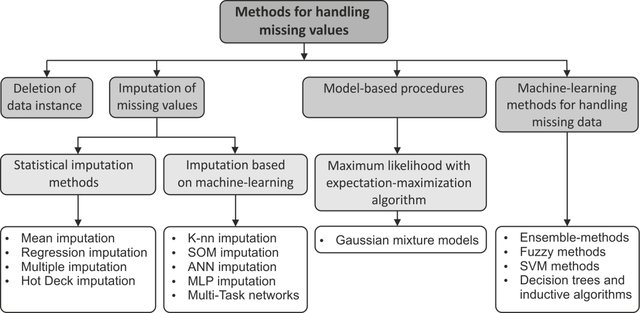

In [ ]:
# make a copy of the original data
df_imp = df.copy()

In [ ]:
xy = np.concatenate((x, y.reshape(-1, 1)), axis=1)
print(xy.shape)
df_imp = pd.DataFrame(xy, columns=data.feature_names + data.target_names)

In [ ]:
# make some missing values in the data
df_imp.loc[df_imp.sample(frac=0.5).index, 'AveRooms'] = np.nan

In [ ]:
df_imp.isna().mean()

In [ ]:
# impute the missing values with the mean
imp = SimpleImputer(strategy='mean')  # strategy can be 'mean', 'median', 'most_frequent', 'constant' (according to `fill_value`)

df_imp['AveRooms_imp'] = imp.fit_transform(df_imp[['AveRooms']])


In [ ]:
#plot distribution of the original and imputed data

fig, ax = plt.subplots(1, 1, figsize=(15, 4))

bins=np.linspace(-10, 30, 40)
# alpha is .3 to make the plot more transparent, log scale to see the small values
sns.histplot(df['AveRooms'], ax=ax, label='Original', alpha=0.3, color='red', bins=bins)
sns.histplot(df_imp['AveRooms_imp'], ax=ax, label='Imputed', alpha=0.3, color='blue', bins=bins)
ax.set_yscale('log')

In [ ]:
df_imp.columns

In [ ]:
knn = KNNImputer(n_neighbors=5)


imp_cols = ['MedInc', 'HouseAge', 'AveRooms', 'AveBedrms', 'Population', 'AveOccup', 'Latitude', 'Longitude']
df_imp['AveRooms_imp_knn'] = knn.fit_transform(df_imp[imp_cols])[:, 2]

sns.histplot(df_imp['AveRooms_imp_knn'][df_imp['AveRooms'].isna()], label='Imputed KNN', alpha=0.3);

In [ ]:
#plot distribution of the original and imputed data

fig, ax = plt.subplots(1, 1, figsize=(15, 4))

bins=np.linspace(-10, 30, 40)
# alpha is .3 to make the plot more transparent, log scale to see the small values
sns.histplot(df['AveRooms'], ax=ax, label='Original', alpha=0.3, color='red', bins=bins)
#sns.histplot(df_imp['AveRooms_imp'], ax=ax, label='Imputed', alpha=0.3, color='blue', bins=bins)
sns.histplot(df_imp['AveRooms_imp_knn'], ax=ax, label='Imputed KNN', alpha=0.3, color='green', bins=bins)
ax.set_yscale('log')

In [ ]:
# make iterative imputer of the data:
# Multivariate imputer that estimates each feature from all the others.
imp = IterativeImputer()

df_imp['AveRooms_imp_iter'] = imp.fit_transform(df_imp[imp_cols])[:, 2]
sns.histplot(df_imp['AveRooms_imp_iter'][df_imp['AveRooms'].isna()], label='Imputed regression', alpha=0.3);

In [ ]:
#plot distribution of the original and imputed data

fig, ax = plt.subplots(1, 1, figsize=(15, 4))

bins=np.linspace(-10, 30, 40)
# alpha is .3 to make the plot more transparent, log scale to see the small values
sns.histplot(df['AveRooms'], ax=ax, label='Original', alpha=0.3, color='red', bins=bins)
#sns.histplot(df_imp['AveRooms_imp'], ax=ax, label='Imputed', alpha=0.3, color='blue', bins=bins)
#sns.histplot(df_imp['AveRooms_imp_knn'], ax=ax, label='Imputed KNN', alpha=0.3, color='green', bins=bins)
sns.histplot(df_imp['AveRooms_imp_iter'], ax=ax, label='Imputed Iter', alpha=0.3, color='yellow', bins=bins)
ax.set_yscale('log')

In [ ]:
# np.float = np.float64  # might be needed for new np for impyute to run

In [ ]:
df_imp['AveRooms_imp_mice'] = mice(df_imp[imp_cols].values)[:, 2]

sns.histplot(df_imp['AveRooms_imp_mice'][df_imp['AveRooms'].isna()], label='Imputed MICE', alpha=0.3);

In [ ]:
#plot distribution of the original and imputed data

fig, ax = plt.subplots(1, 1, figsize=(15, 4))

bins=np.linspace(-10, 30, 40)
# alpha is .3 to make the plot more transparent, log scale to see the small values
sns.histplot(df['AveRooms'], ax=ax, label='Original', alpha=0.3, color='red', bins=bins)
#sns.histplot(df_imp['AveRooms_imp'], ax=ax, label='Imputed', alpha=0.3, color='blue', bins=bins)
#sns.histplot(df_imp['AveRooms_imp_knn'], ax=ax, label='Imputed KNN', alpha=0.3, color='green', bins=bins)
sns.histplot(df_imp['AveRooms_imp_iter'], ax=ax, label='Imputed Iter', alpha=0.3, color='yellow', bins=bins)
sns.histplot(df_imp['AveRooms_imp_mice'][df_imp['AveRooms'].isna()], label='Imputed MICE', alpha=0.3, color='purple', bins=bins)
ax.set_yscale('log')

Please explore the other imputation methods in the `impyute` library.
There is a number of them for different types of data.

# Step 3. Data Transformation Pipeline

We see by now that we have a number of preprocessing steps even before we start fitting the model. To simplify our work we can use the `Pipeline` class from `sklearn.pipeline` module.

The aim of a pipeline is to assemble several preprocessing steps and a model in a single object.

In [ ]:
data = fetch_california_housing()
x, y = data.data, data.target

col_names = data.feature_names
tgt_names = data.target_names

xy = np.concatenate((x, y.reshape(-1, 1)), axis=1)

df = pd.DataFrame(xy, columns=col_names + tgt_names)

In [ ]:
# 'Longitude', 'Latitude', 'HouseAge' - MinMaxScaler
# 'Population', 'AveOccup', 'AveRooms', 'AveBedrms', 'MedInc' - PowerTransformer

# standardize the target
pipeline_min_max = Pipeline([
    ('min_max_scaler', MinMaxScaler())
])

pipeline_power = Pipeline([
    ('power_transformer', PowerTransformer())
])


pipeline_preproc = ColumnTransformer([
    ('min_max_scaler', pipeline_min_max, ['Longitude', ]),
    ('power_transformer', pipeline_power, ['Population', ]),
],
    remainder='passthrough')


In [ ]:
pipeline_preproc.fit(df)
df_preproc =  pd.DataFrame(pipeline_preproc.transform(df), columns=pipeline_preproc.get_feature_names_out())

In [ ]:
df_preproc

we can expand the pipeline to impute the missing values with the MICE method.

In [ ]:
pipeline_impute = Pipeline([
    ('mice_imputer', mice)
])

pipeline_preproc = ColumnTransformer([
    ('min_max_scaler', pipeline_min_max, ['Longitude', 'Latitude', 'HouseAge']),
    ('power_transformer', pipeline_power, ['Population', 'AveOccup', 'AveRooms', 'AveBedrms', 'MedInc']),
],
    remainder='passthrough')

pipeline = Pipeline([
    ('preproc', pipeline_preproc),
    ('impute', pipeline_impute),
    ('pass', 'passthrough')
])

pipeline.fit(df)
df_preproc =  pd.DataFrame(pipeline.transform(df), columns=pipeline.get_feature_names_out())
df_preproc.head()

In [ ]:
# we need a custom funciton to make the pipeline work with the mice imputer function

def mice_imputer(data_x):
    if np.isnan(data_x).any():
        return mice(data_x)
    else:
        return data_x

pipeline_impute = Pipeline([
    ('mice_imputer', FunctionTransformer(mice_imputer))
])

pipeline = Pipeline([
    ('preproc', pipeline_preproc),
    ('impute', pipeline_impute),
    ('pass', 'passthrough')
])

pipeline.fit(df)
df_preproc =  pd.DataFrame(pipeline.transform(df), columns=pipeline_preproc.get_feature_names_out())
df_preproc.head()


In [ ]:
%%time
# finally we can add a model to the pipeline. let's use a random forest regressor

pipeline = Pipeline([
    ('preproc', pipeline_preproc),
    ('impute', pipeline_impute),
    ('model', RandomForestRegressor())
])

tgt_name = tgt_names[0]
df_train, df_test = train_test_split(df, test_size=0.2)
pipeline.fit(df_train[col_names], df_train[tgt_name])

y_pred = pipeline.predict(df_test[col_names])

mse = mean_squared_error(df_test[tgt_name], y_pred)
r2 = r2_score(df_test[tgt_name], y_pred)
print(f'mse={mse:.3f}, r2={r2:.3f}')

# plot the predicted vs true values

fig, ax = plt.subplots(1, 1, figsize=(5, 5))
sns.scatterplot(x=df_test[tgt_name], y=y_pred, ax=ax, alpha=0.3)
ax.set_xlabel('True')
ax.set_ylabel('Predicted')

psc()

In [ ]:
%%time
# we can also use the pipeline to do CV and grid search

param_grid = {
    'model__n_estimators': [10, 100, 200, 400],  # ToDo: test if 400 is ok on colab
    'model__max_depth': [1, 20, 100],
}

grid_search = GridSearchCV(pipeline, param_grid, cv=2, n_jobs=2, verbose=2)

grid_search.fit(df_train[col_names], df_train[tgt_name])

In [ ]:
print(grid_search.best_params_)

In [ ]:
grid_search.cv_results_

In [ ]:
res = grid_search.cv_results_
cfgs = [str(p) for p in res['params']]
scores = res['mean_test_score']
scores_std = res['std_test_score']

time = res['mean_fit_time']
time_std = res['std_fit_time']

# plot the results
fig, ax = plt.subplots(1, 1, figsize=(10, 5))
ax.errorbar(cfgs, scores, yerr=scores_std, fmt='o')
ax.set_xticklabels(cfgs, rotation=90)
ax.set_ylabel('mean test score (r2)')
ax.set_xlabel('configurations')
psc()


# plot the time

fig, ax = plt.subplots(1, 1, figsize=(10, 5))
ax.errorbar(cfgs, time, yerr=time_std, fmt='o')
ax.set_xticklabels(cfgs, rotation=90)
ax.set_ylabel('mean fit time, sec')
ax.set_xlabel('configurations')
psc()

In [ ]:
y_pred = grid_search.predict(df_test[col_names])

mse = mean_squared_error(df_test[tgt_name], y_pred)
r2 = r2_score(df_test[tgt_name], y_pred)

print(f'mse={mse:.3f}, r2={r2:.3f}')

# plot the predicted vs true values

fig, ax = plt.subplots(1, 1, figsize=(5, 5))
sns.scatterplot(x=df_test[tgt_name], y=y_pred, ax=ax, alpha=0.3)
ax.set_xlabel('True')
ax.set_ylabel('Predicted')
psc()

It is not advised to use the pipeline for the metric evaluation, e.g. see the discussion [here](https://stackoverflow.com/questions/43787107/use-a-metric-after-a-classifier-in-a-pipeline)    

# Step 4. Saving and Loading Models

The easiest is to use the `joblib` library, which is more efficient on objects that carry large numpy arrays internally as is often the case for fitted scikit-learn estimators.
Saving the model with simple `pickle` can be problematic, as it can lead to compatibility issues between different Python versions.

In [ ]:
# save the pipeline
dump(pipeline, 'pipeline.joblib')

# load the pipeline
pipeline_loaded = load('pipeline.joblib')

# use the loaded pipeline
y_pred = pipeline_loaded.predict(df_test[col_names])

mse = mean_squared_error(df_test[tgt_name], y_pred)
print(f'mse={mse:.3f}')

# plot the predicted vs true values


# Step 5. Data IO

In [ ]:
# save the data

# csv is human-readable, but not the most efficient
df.to_csv('california_housing.csv', index=False)

# feather is the most efficient for pandas dataframes
df.to_feather('california_housing.feather')

In [ ]:

# load the data, testing time

%timeit df_csv = pd.read_csv('california_housing.csv')
%timeit df_feather = pd.read_feather('california_housing.feather')

In [ ]:
# print file sizes

print(f'csv: {os.path.getsize("california_housing.csv") / 1024 / 1024:.3f} MB')
print(f'feather: {os.path.getsize("california_housing.feather") / 1024 / 1024:.3f} MB')

# Step 6. Data Visualization

We will end this course with same message as we started it: the importance of data visualization.
After all, the main goal of the data analysis is to make the data understandable and interpretable.
Once we did all the ML work, we need to present the results in a way that is understandable - to the stakeholders, to the team, to the scientific community, to the public, and most importantly to ourselves.


We can use plotly for interactive plots:


In [ ]:
fig = px.scatter(df, x='AveRooms', y='AveBedrms', color='MedHouseVal', hover_data=['Latitude', 'Longitude'])

In [ ]:
df['idx'] = df.index

In [ ]:
external_stylesheets = ['https://codepen.io/chriddyp/pen/bWLwgP.css']
app = Dash('Houses', external_stylesheets=external_stylesheets)



app.layout = html.Div([
    html.Div([

        html.Div([
            dcc.Dropdown(
                df.columns,
                'AveRooms',
                id='crossfilter-xaxis-column',
            ),
            dcc.RadioItems(
                ['Linear', 'Log'],
                'Linear',
                id='crossfilter-xaxis-type',
                labelStyle={'display': 'inline-block', 'marginTop': '5px'}
            )
        ],
        style={'width': '32%', 'float': 'left', 'display': 'inline-block'}),

        html.Div([
            dcc.Dropdown(
                df.columns,
                'AveBedrms',
                id='crossfilter-yaxis-column'
            ),
            dcc.RadioItems(
                ['Linear', 'Log'],
                'Linear',
                id='crossfilter-yaxis-type',
                labelStyle={'display': 'inline-block', 'marginTop': '5px'}
            )
        ], style={'width': '32%', 'float': 'left', 'display': 'inline-block'}),
        
        html.Div([
            dcc.Dropdown(
                df.columns,
                'MedHouseVal',
                id='crossfilter-zaxis-column'
            )
        ], style={'width': '32%', 'float': 'left', 'display': 'inline-block'})
    ], style={
        'padding': '10px 5px'
    }),

    html.Div([
        dcc.Graph(
            id='crossfilter-indicator-scatter',
            #hoverData={'points': [{'customdata': None}]},
            selectedData={'points': [{'customdata': None}]}
            
        )
    ], style={'width': '49%', 'display': 'inline-block', 'padding': '0 20'}),
    html.Div([
        dcc.Graph(id='x-plot'),
        dcc.Graph(id='y-plot'),
    ], style={'display': 'inline-block', 'width': '49%'}),

    html.Div(dcc.Slider(
        df['MedHouseVal'].min(),
        df['MedHouseVal'].max(),
        step=None,
        id='crossfilter-houseval--slider',
        value=df['MedHouseVal'].max(),
        marks={str(v): str(v) for v in range(int(df['MedHouseVal'].max()+1))}
    ), style={'width': '49%', 'padding': '0px 20px 20px 20px'})
])


@callback(
    Output('crossfilter-indicator-scatter', 'figure'),
    Input('crossfilter-xaxis-column', 'value'),
    Input('crossfilter-yaxis-column', 'value'),
    Input('crossfilter-zaxis-column', 'value'),
    Input('crossfilter-xaxis-type', 'value'),
    Input('crossfilter-yaxis-type', 'value'),
    Input('crossfilter-houseval--slider', 'value'))
def update_graph(xaxis_column_name, yaxis_column_name, zaxis_column_name,
                 xaxis_type, yaxis_type,
                 price_value):
    dff = df[df['MedHouseVal'] < price_value]



    fig = px.scatter(x=dff[xaxis_column_name],
                     y=dff[yaxis_column_name],
                     color=dff[zaxis_column_name],
                     hover_name=dff['MedHouseVal']
                     )

    fig.update_traces(customdata=dff['idx'])

    fig.update_xaxes(title=xaxis_column_name, type='linear' if xaxis_type == 'Linear' else 'log')

    fig.update_yaxes(title=yaxis_column_name, type='linear' if yaxis_type == 'Linear' else 'log')

    fig.update_layout(margin={'l': 40, 'b': 40, 't': 10, 'r': 0}, hovermode='closest')

    return fig


def create_plot(dff, axis_type, axis):

    fig = px.scatter(dff, x='MedHouseVal', y=axis)

    fig.update_traces(mode='markers')

    fig.update_xaxes(showgrid=False)

    fig.update_yaxes(type='linear' if axis_type == 'Linear' else 'log')

    fig.add_annotation(x=0, y=0.85, xanchor='left', yanchor='bottom',
                       xref='paper', yref='paper', showarrow=False, align='left',
                       text=axis)

    fig.update_layout(height=225, margin={'l': 20, 'b': 30, 'r': 10, 't': 10})

    return fig


@callback(
    Output('x-plot', 'figure'),
    Input('crossfilter-indicator-scatter', 'selectedData'),
    Input('crossfilter-xaxis-column', 'value'),
    Input('crossfilter-xaxis-type', 'value'))
def update_x_timeseries(hoverData, xaxis_column_name, axis_type):
    idx = [p['customdata'] for p in hoverData['points']]
    idx = [i for i in idx if i is not None]
    dff = df.iloc[idx]
    return create_plot(dff, axis_type, xaxis_column_name)


@callback(
    Output('y-plot', 'figure'),
    Input('crossfilter-indicator-scatter', 'selectedData'),
    Input('crossfilter-yaxis-column', 'value'),
    Input('crossfilter-yaxis-type', 'value'))
def update_y_timeseries(hoverData, yaxis_column_name, axis_type):
    idx = [p['customdata'] for p in hoverData['points']]
    idx = [i for i in idx if i is not None]
    dff = df.iloc[idx]
    return create_plot(dff, axis_type, yaxis_column_name)


app.run(debug=True)


# Workshop

Use your data to exercise the same steps as in the notebook.

Alternatively, you can use the extended house price data: Subset of the Ames Houses dataset: http://jse.amstat.org/v19n3/decock.pdf



In [ ]:
# load the data
path = os.path.abspath('.')+'/colab_material.tgz'
url = 'https://github.com/neworldemancer/DSF5/raw/master/colab_material.tgz'

r = requests.get(url)

with open(path, 'wb') as f:
    f.write(r.content)
    
tar = tarfile.open(path, "r:gz")
tar.extractall()
tar.close()

In [ ]:
path = 'data/AmesHousing.csv'
df = pd.read_csv(path, na_values=('NaN', ''), keep_default_na=False)
rename_dict = {k:k.replace(' ', '').replace('/', '') for k in df.keys()}  # simplify the column names
df.rename(columns=rename_dict, inplace=True)

In [ ]:
df.head()

# Further reading

* [scikit-learn](https://scikit-learn.org/stable/)
* [hierarchical clustering](https://scikit-learn.org/stable/modules/clustering.html#hierarchical-clustering)
* [dash](https://dash.plotly.com/)
* [plotly](https://plotly.com/python/)
* [streamlit](https://streamlit.io/)
* [MLFlow](https://mlflow.org/)

# Courses and support at DSL

* [Data Science Lab](https://www.dsl.unibe.ch)
* [Data Science Lab Walk-in](https://www.dsl.unibe.ch/support/walk_in/)